In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
import pickle
import os
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow import keras 
from tensorflow.keras import layers
from keras.models import Model
from sklearn.metrics import *
from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.applications.densenet import DenseNet169
from keras.layers import Input

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def augment(path,IMG_DIM):

  
  datagen = ImageDataGenerator(rotation_range=40,width_shift_range=.2,height_shift_range=.2,shear_range=.2,zoom_range=.2,horizontal_flip=True,fill_mode='nearest')
  #to list all directories in a specific folder
  directories = os.listdir(path)
  files_path = []
  labels = []
  for i in range(len(directories)):
    ls = []
    curPath = path +'/' +directories[i] + '/*'
    ls = glob.glob(curPath)
    temp = []
    for img in ls:
      x = img_to_array(load_img(img,target_size = IMG_DIM))
      x = x.reshape((1,)+x.shape)
      temp.append(x)
    
    i = 0
    target = 800
    for batch in datagen.flow(temp,batch_size=4,save_to_dir=curPath[:-1],save_format='jpg'):
      i += 1
      if len(ls) + i*4>800:
        break
#Creating Frame
def createFrame(path,IMG_DIM):
  train_imgs = []
  labels = []
  #getting all folder name
  directories = os.listdir(path)
  for i in range(len(directories)):
    ls = []
    temp = []
    curPath = path +'/' +directories[i] + '/*'
    #getting all files name
    ls = glob.glob(curPath)
    for img in ls:
      x = img_to_array(load_img(img,target_size = IMG_DIM))
      temp.append(x)
    #print(len(ls))
    train_imgs  = train_imgs + temp
    label = []
    label = [i]*len(ls)
    labels += label
  df = pd.DataFrame(list(zip(train_imgs,labels)))
  df = df.sample(frac = 1) 
  return df

def kFold(df):
  df['kfold'] = -1
  df = df.reset_index(drop=True)
  y = df[1]
  kf = model_selection.StratifiedKFold(n_splits=5)
  for f,(t_,v_) in enumerate(kf.split(X=df,y=y)):
    df.loc[v_,'kfold'] = f
  return df

In [ ]:

import sys
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

path1 = '/content/drive/MyDrive/resized_original_aug/train'
if path1[-1]=='/':
  path1 = path1[:-1]
num_epochs = 7


IMG_WIDTH=200
IMG_HEIGHT=200
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT,3)

df = createFrame(path1,IMG_DIM)
df1 = createFrame('/content/drive/MyDrive/resized_original_aug/test',IMG_DIM)

#sir
frames=[df, df1]
df=pd.concat(frames)
df = kFold(df)

target_names = os.listdir(path1)
num_classes = len(target_names)

In [ ]:
from keras.optimizers import adam
#Customized CNN models
def DenseNet(train_imgs,train_labels,test_imgs,test_labels,class_no,num_epochs=20):
  print("-------------------------------------DENSENET--------------------------------------------")
  input_shape_densenet = (200, 200, 3)
  base_model = DenseNet169(input_shape=(200,200,3), 
                         include_top=False,
                         weights="imagenet")
  x = keras.layers.Conv2D(1024, (3, 3), activation='relu')(base_model.output)
  x = keras.layers.MaxPooling2D(pool_size=(3, 3))(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(256, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  x = layers.Dense(128,activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = keras.layers.Dense(class_no, activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=x)
  
  model.compile(optimizer = RMSprop(learning_rate=2e-5),loss='categorical_crossentropy',metrics=['acc'])
  history = model.fit(train_imgs, train_labels, batch_size=16, epochs=num_epochs,verbose=1,validation_data=(test_imgs,test_labels))
  print("------------------------------------------------------------------------------------------")
  #print(model.accuracy)
  acc = history.history['acc']
  
  val_acc = history.history['val_acc']
  iterations = range(1,21)
  plt.plot(iterations, acc, 'g', label='Training accuracy')
  plt.plot(iterations, val_acc, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Iterations')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show() 
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  iterations = range(1,21)
  plt.plot(iterations, train_loss, 'g', label='Training loss')
  plt.plot(iterations, val_loss, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  return model,acc

In [ ]:
for i in range(1,2):
 # print("-------------------------------------Fold = ")
  print(i)
 # print("-------------------------------------")
  dfTrain = df[df['kfold']!=i]
  dfTest = df[(df['kfold']==i)] 
  train_imgs = list(dfTrain[0])
  train_imgs = np.array(train_imgs)
  train_imgs = train_imgs/255
  train_labels = np.array(dfTrain[1])
  encoder = LabelEncoder()
  encoder.fit(train_labels)
  train_labels = encoder.transform(train_labels)
  train_labels = np_utils.to_categorical(train_labels)
  test_imgs= list(dfTest[0])
  test_imgs = np.array(test_imgs)
  test_imgs = test_imgs/255
  test_labels = np.array(dfTest[1])
  encoder = LabelEncoder()
  encoder.fit(test_labels)
  test_labels = encoder.transform(test_labels)
  test_labels = np_utils.to_categorical(test_labels)
 

1


-------------------------------------DENSENET--------------------------------------------
51877672/51877672 [==============================] - 2s 0us/step
Epoch 1/20
431/431 [==============================] - 197s 238ms/step - loss: 0.5649 - acc: 0.7918 - val_loss: 0.1070 - val_acc: 0.9663
Epoch 2/20
431/431 [==============================] - 93s 217ms/step - loss: 0.1100 - acc: 0.9614 - val_loss: 0.0351 - val_acc: 0.9878
Epoch 3/20
431/431 [==============================] - 94s 219ms/step - loss: 0.0432 - acc: 0.9842 - val_loss: 0.0559 - val_acc: 0.9861
Epoch 4/20
431/431 [==============================] - 95s 221ms/step - loss: 0.0281 - acc: 0.9913 - val_loss: 0.0404 - val_acc: 0.9901
Epoch 5/20
431/431 [==============================] - 95s 221ms/step - loss: 0.0198 - acc: 0.9932 - val_loss: 0.0717 - val_acc: 0.9866
Epoch 6/20
431/431 [==============================] - 95s 221ms/step - loss: 0.0140 - acc: 0.9958 - val_loss: 0.0569 - val_acc: 0.9913
Epoch 7/20
431/431 [==============

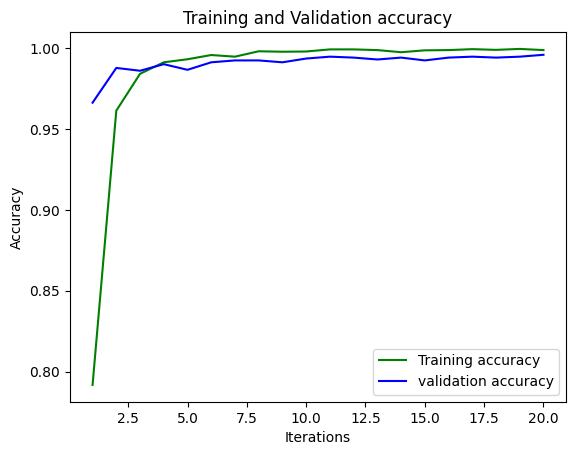

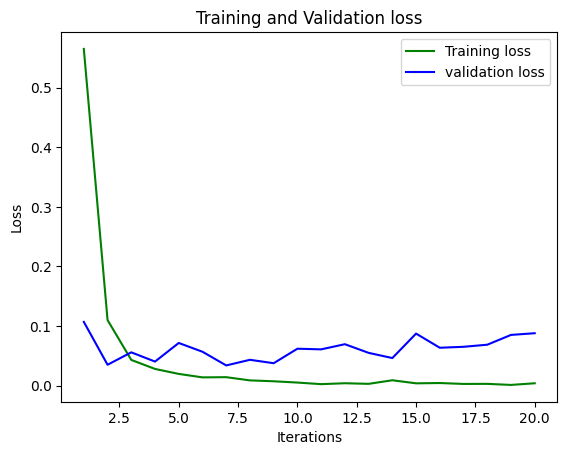

108/108 [==============================] - 7s 61ms/step - loss: 0.0880 - acc: 0.9959


[0.08800198137760162, 0.9959349632263184]

In [ ]:
model0,acc1 = DenseNet(train_imgs,train_labels,test_imgs, test_labels,class_no=num_classes,num_epochs=20)

model0.evaluate(test_imgs, test_labels, batch_size=16)

In [ ]:
res1 = model0.predict(test_imgs)
leb1 = np.argmax(res1,axis=-1)
actual = np.argmax(test_labels,axis=-1)

In [ ]:

  print('Densenet-169 base learner')
  print(classification_report(actual, leb1,target_names = target_names,digits=4))

Densenet-169 base learner
                        precision    recall  f1-score   support

      late_leaf_spot_1     1.0000    0.9817    0.9908       382
          early_rust_1     1.0000    1.0000    1.0000       297
     early_leaf_spot_1     0.9802    1.0000    0.9900       346
                rust_1     1.0000    1.0000    1.0000       345
nutrition_deficiency_1     1.0000    1.0000    1.0000       352

              accuracy                         0.9959      1722
             macro avg     0.9960    0.9963    0.9961      1722
          weighted avg     0.9960    0.9959    0.9959      1722



In [ ]:
import seaborn as sns
cm=confusion_matrix(actual,leb1)
fig,ax=plt.subplots()
sns.heatmap(cm,annot=True,fmt='d',linewidth=3,cmap='Blues')
plt.xlabel("Confusion Matrix",fontsize=18,labelpad=20)
ax.xaxis.tick_top()
plt.ylabel("True",fontsize=14,rotation=0,labelpad=30)
plt.yticks(rotation=0)
plt.title("Predicted",fontsize=14,pad=10)
plt.show()
